In [26]:
#! pip install tqdm
#! pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu11\

Looking in indexes: http://pypi.douban.com/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 15.5 MB/s eta 0:00:00


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import tree
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.version.cuda)
print(torch.__version__)

cuda:0
11.3
1.11.0+cu113


In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

print('train_data.shape =', train_data.shape)
print('test_data.shape =', test_data.shape)

train_data.shape = (39407, 39)
test_data.shape = (26272, 38)


In [3]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print('train_data.columns =', train_data.columns)
print('test_data.columns =', test_data.columns)

         Id             Address  Sold Price  \
0  19633278        2029 Kent Dr   3308000.0   
1  19687145  528 Shadowgraph Dr    730000.0   
2  19606535      4029 Payne Ave   1450000.0   
3  19807250   2109 Saffarian Ct    883000.0   

                                             Summary       City    Zip State  
0  Located in the desirable Highlands neighborhoo...  Los Altos  94024    CA  
1  Move-in ready second floor unit with vaulted c...   San Jose  95110    CA  
2  Great opportunity to make this home uniquely y...   San Jose  95117    CA  
3  Remodeled and well-maintained 4 bedrooms/2 bat...   San Jose  95121    CA  
train_data.columns = Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary School Score', 'Elementary School Distance',
       'Middle

In [4]:
train_data_ = train_data.loc[:, train_data.columns != 'Sold Price']
train_data_ = train_data_.loc[:, train_data_.columns != 'Summary']
test_data_ = test_data.loc[:, test_data.columns != 'Summary']
#print(len(train_data_.iloc[:, 1:].columns))
#print(len(test_data.iloc[:, 1:].columns))
all_features = pd.concat([train_data_.iloc[:, 1:], test_data.iloc[:, 1:]])

In [5]:
numeric_features = all_features.loc[:, all_features.dtypes != 'object']
numeric_features = numeric_features.apply(
    lambda x: (x-x.mean()/x.std()))
numeric_features = numeric_features.fillna(0)
numeric_features.head()

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Zip
0,1949.927488,13067.975262,3.547299,1.57702,2831.637584,1.959643,1.959687,5.949248,-0.622733,4.808502,0.703011,4.660035,1.167523,3.199999e+06,38897.477543,93967.391449
1,1977.927488,918.975262,0.547299,0.00000,870.637584,-0.040357,-0.040313,-0.050752,-0.222733,1.808502,0.603011,2.660035,0.467523,5.899995e+05,7469.477543,95053.391449
2,1953.927488,6659.975262,0.547299,-0.42298,1465.637584,0.959643,0.959687,1.949248,-0.522733,2.808502,0.203011,3.660035,0.967523,1.325999e+06,18588.477543,95060.391449
3,1969.927488,4672.975262,0.547299,-0.42298,1324.637584,1.959643,1.959687,2.949248,-0.022733,0.000000,0.000000,4.660035,-0.432477,8.519995e+05,12199.477543,95064.391449
4,1968.927488,7099.975262,1.547299,-0.42298,3099.637584,1.959643,1.959687,2.949248,0.577267,2.808502,-0.596989,5.660035,-0.432477,1.784999e+06,20023.477543,93973.391449


In [37]:
n_train = train_data.shape[0]
train_features = torch.tensor(numeric_features[:n_train].to_numpy(), dtype=torch.float32)
test_features = torch.tensor(numeric_features[n_train:].to_numpy(), dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].to_numpy().reshape(-1,1), dtype=torch.float32)

print('train_features.shape =', train_features.shape)
print('test_features.shape =', test_features.shape)
print('train_labels.shape =', train_labels.shape)
#print('X_train.shape =', X_train.shape)

train_features.shape = torch.Size([39407, 16])
test_features.shape = torch.Size([26272, 16])
train_labels.shape = torch.Size([39407, 1])


In [7]:
loss = nn.MSELoss()
in_features = train_features.shape[-1]
print('in_features =', in_features)

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256),
                       nn.ReLU(),
                       nn.Linear(256, 64),
                       nn.ReLU(),
                       nn.Linear(64, 1))
    return net

in_features = 16


In [23]:
def log_rmse(net, features, labels):
#     print('log_rmse')
    clipped_preds = torch.clip(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [44]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    net = net.to(device)
    train_ls, test_ls = [],[]
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    if test_labels is not None:
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in tqdm(range(num_epochs)):
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        #print(float(train_ls[-1]), float(test_ls[-1]))
        print(f'epoch = {epoch+1}, train_loss = {float(train_ls[-1]):f}, test_loss = {float(test_ls[-1]):f}')
    return train_ls, test_ls

In [46]:
def train_and_pred(train_features, test_features,
                   train_labels, test_data, num_epochs,
                   learning_rate, weight_decay, batch_size):
    net = get_net()
    
    # split train data and test data.
    X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.3)
    
    train_ls, test_ls  = train(net,
                         X_train, y_train,
                         X_test, y_test,
                         num_epochs, learning_rate,
                         weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls,test_ls], xlabel='epoch',
            ylabel='log rmse', legend=['train', 'test'], xlim=[1, num_epochs], yscale='log')
    #print(f'train log rmse {float(train_ls[-1])}')
    #print('test_features.shape =', test_features.shape)
    preds = net(test_features.to(device)).detach().cpu().numpy()
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return submission

 10%|████▏                                     | 1/10 [00:00<00:05,  1.52it/s]

epoch = 1, train_loss = 1.319131851196289, test_loss = 1.3594070672988892


 20%|████████▍                                 | 2/10 [00:01<00:05,  1.43it/s]

epoch = 2, train_loss = 1.5135719776153564, test_loss = 1.5825393199920654


 30%|████████████▌                             | 3/10 [00:01<00:04,  1.57it/s]

epoch = 3, train_loss = 8.641242980957031, test_loss = 8.645517349243164


 40%|████████████████▊                         | 4/10 [00:02<00:03,  1.50it/s]

epoch = 4, train_loss = 5.809340953826904, test_loss = 5.78117036819458


 50%|█████████████████████                     | 5/10 [00:03<00:03,  1.59it/s]

epoch = 5, train_loss = 1.8070913553237915, test_loss = 1.871074914932251


 60%|█████████████████████████▏                | 6/10 [00:03<00:02,  1.63it/s]

epoch = 6, train_loss = 13.572449684143066, test_loss = 13.546228408813477


 70%|█████████████████████████████▍            | 7/10 [00:04<00:01,  1.51it/s]

epoch = 7, train_loss = 8.081598281860352, test_loss = 8.06476879119873


 80%|█████████████████████████████████▌        | 8/10 [00:05<00:01,  1.52it/s]

epoch = 8, train_loss = 7.705761432647705, test_loss = 7.690795421600342


 90%|█████████████████████████████████████▊    | 9/10 [00:05<00:00,  1.54it/s]

epoch = 9, train_loss = 7.453561782836914, test_loss = 7.461778163909912


100%|█████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]

epoch = 10, train_loss = 6.938666820526123, test_loss = 6.935575485229492


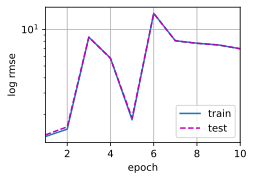

In [47]:
k, num_epochs, lr, weight_decay, batch_size = 5, 10, 0.1, 0, 128

submission = train_and_pred(train_features, test_features, train_labels, test_data,
                            num_epochs, lr, weight_decay, batch_size)

In [43]:
train_ls = [0.8]
test_ls = [0.7]
print(f'train_loss = {float(train_ls[-1])}, test_loss = {float(test_ls[-1])}')

train_loss = 0.8, test_loss = 0.7
